In [110]:
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import coo_matrix
from sklearn.cluster import SpectralCoclustering

sns.set_theme(style="whitegrid")


In [111]:
project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_dir = project_root / "data"
graph_paths = sorted(data_dir.glob("contract_graph_20??.graphml"))
if not graph_paths:
    raise FileNotFoundError("No GraphML files found. Run scripts/build_contract_graph.py first.")

graph_paths


[WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_2020.graphml'),
 WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_2021.graphml'),
 WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_2022.graphml'),
 WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_2023.graphml'),
 WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_2024.graphml'),
 WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_2025.graphml')]

In [112]:
combined_graph = nx.MultiDiGraph()
for path in graph_paths:
    g = nx.read_graphml(path)
    g_multi = nx.MultiDiGraph()
    g_multi.add_nodes_from(g.nodes(data=True))
    g_multi.add_edges_from(g.edges(data=True))
    combined_graph = nx.compose(combined_graph, g_multi)

combined_summary = {
    "nodes": combined_graph.number_of_nodes(),
    "edges": combined_graph.number_of_edges(),
    "graph_paths": [p.name for p in graph_paths],
}
combined_summary


{'nodes': 141652,
 'edges': 225225,
 'graph_paths': ['contract_graph_2020.graphml',
  'contract_graph_2021.graphml',
  'contract_graph_2022.graphml',
  'contract_graph_2023.graphml',
  'contract_graph_2024.graphml',
  'contract_graph_2025.graphml']}

# run from here 

In [127]:
buyer_winner_graph = nx.Graph()

for node, attrs in combined_graph.nodes(data=True):
    if attrs.get("type") == "organisation":
        buyer_winner_graph.add_node(node, **attrs)

lot_nodes = [n for n, attrs in combined_graph.nodes(data=True) if attrs.get("type") == "lot"]

for lot in lot_nodes:
    buyers = [pred for pred in combined_graph.predecessors(lot) if combined_graph.nodes[pred].get("role") == "buyer"]
    winners = [succ for succ in combined_graph.successors(lot) if combined_graph.nodes[succ].get("role") == "winner"]
    if not buyers or not winners:
        continue
    for buyer in buyers:
        for winner in winners:
            if buyer_winner_graph.has_edge(buyer, winner):
                buyer_winner_graph[buyer][winner]["weight"] += 1
            else:
                buyer_winner_graph.add_edge(buyer, winner, weight=1)

buyer_winner_summary = {
    "nodes": buyer_winner_graph.number_of_nodes(),
    "edges": buyer_winner_graph.number_of_edges(),
    "isolates": nx.number_of_isolates(buyer_winner_graph),
}
buyer_winner_summary


{'nodes': 17779, 'edges': 38392, 'isolates': 137}

In [128]:
import igraph as ig
import leidenalg as la


In [129]:
def nx_to_igraph(G: nx.Graph, weight: str = "weight") -> tuple[ig.Graph, dict[int, str], dict[str, int]]:
    """Convert an undirected NetworkX graph with string node IDs into igraph."""
    nodes = list(G.nodes())
    index_from_node = {node: idx for idx, node in enumerate(nodes)}
    node_from_index = {idx: node for node, idx in index_from_node.items()}

    g = ig.Graph()
    g.add_vertices(len(nodes))
    g.vs["name"] = nodes

    edges = [(index_from_node[u], index_from_node[v]) for u, v in G.edges()]
    g.add_edges(edges)

    # Edge weights
    weights = [G[u][v].get(weight, 1.0) for u, v in G.edges()]
    g.es["weight"] = weights

    return g, node_from_index, index_from_node


In [130]:
def leiden_cpm(G: nx.Graph, gamma: float = 0.5, weight: str = "weight") -> tuple[list[set[str]], dict[str, str]]:
    """Run Leiden CPM on a NetworkX graph and return communities + node->cluster map."""
    g, node_from_index, index_from_node = nx_to_igraph(G, weight=weight)
    partition = la.find_partition(
        g,
        la.CPMVertexPartition,
        resolution_parameter=gamma,
        weights=g.es["weight"],
    )

    communities = []
    cluster_map_local: dict[str, str] = {}
    for idx, comm in enumerate(partition):
        cluster_id = f"leiden_{gamma:.2f}_{idx:04d}"
        node_names = {node_from_index[i] for i in comm}
        communities.append(node_names)
        for node in node_names:
            cluster_map_local[node] = cluster_id
    return communities, cluster_map_local


In [131]:
def split_sides(G: nx.Graph, attr: str = "type"):
    """Split nodes into buyer, winner, and dual-role lists based on an attribute."""
    buyers, winners, both = [], [], []
    for node, data in G.nodes(data=True):
        value = (data.get(attr) or data.get("role") or data.get("bipartite") or "").lower()
        if "buyer" in value and "winner" in value:
            both.append(node)
        elif "buyer" in value:
            buyers.append(node)
        elif "winner" in value:
            winners.append(node)
    return buyers, winners, both


def biadjacency(G: nx.Graph, buyers: list[str], winners: list[str], weight: str = "weight") -> coo_matrix:
    """Build a weighted buyer-by-winner biadjacency matrix."""
    accumulator: dict[tuple[int, int], float] = defaultdict(float)
    buyer_pos = {node: idx for idx, node in enumerate(buyers)}
    winner_pos = {node: idx for idx, node in enumerate(winners)}

    for u, v, data in G.edges(data=True):
        w = data.get(weight, 1.0)
        if w is None:
            continue
        try:
            w = float(w)
        except (TypeError, ValueError):
            continue
        if not np.isfinite(w):
            continue
        if u in buyer_pos and v in winner_pos:
            accumulator[(buyer_pos[u], winner_pos[v])] += w
        if v in buyer_pos and u in winner_pos:
            accumulator[(buyer_pos[v], winner_pos[u])] += w

    if not accumulator:
        raise ValueError("No buyer-winner edges found for co-clustering.")

    rows, cols, vals = zip(*[(i, j, w) for (i, j), w in accumulator.items()])
    return coo_matrix((vals, (rows, cols)), shape=(len(buyers), len(winners))).tocsr()


def cocluster_min30(
    G: nx.Graph,
    k: int = 80,
    weight: str = "weight",
    type_attr: str = "type",
    min_each_side: int = 15,
):
    """Spectral co-clustering with minimum size enforcement."""
    buyers, winners, both = split_sides(G, attr=type_attr)
    matrix = biadjacency(G, buyers, winners, weight=weight)

    # Drop isolated buyers/winners to avoid NaNs
    row_strength = np.asarray(matrix.sum(axis=1)).ravel()
    col_strength = np.asarray(matrix.sum(axis=0)).ravel()

    buyer_mask = row_strength > 0
    winner_mask = col_strength > 0

    if buyer_mask.sum() == 0 or winner_mask.sum() == 0:
        raise ValueError("Biadjacency matrix has no non-zero rows or columns after cleaning.")

    if buyer_mask.sum() != len(buyers):
        matrix = matrix[buyer_mask, :]
        buyers = [b for keep, b in zip(buyer_mask, buyers) if keep]
        row_strength = row_strength[buyer_mask]

    if winner_mask.sum() != len(winners):
        matrix = matrix[:, winner_mask]
        winners = [w for keep, w in zip(winner_mask, winners) if keep]
        col_strength = col_strength[winner_mask]

    # Row/column scaling (TF-IDF style)
    row_strength[row_strength == 0] = 1
    col_strength[col_strength == 0] = 1
    idf = np.log((1 + matrix.shape[0]) / (1 + col_strength)) + 1.0

    scaled = matrix.multiply(idf)
    scaled = scaled.multiply(1 / np.sqrt(row_strength)[:, None])

    model = SpectralCoclustering(n_clusters=k, random_state=0)
    model.fit(scaled)

    blocks: list[dict[str, set[str]]] = []
    for group in range(k):
        buyer_block = {buyers[idx] for idx, label in enumerate(model.row_labels_) if label == group}
        winner_block = {winners[idx] for idx, label in enumerate(model.column_labels_) if label == group}
        if buyer_block or winner_block:
            blocks.append({"B": buyer_block, "W": winner_block})

    def build_block_maps(current_blocks: list[dict[str, set[str]]]):
        node_to_b = {node: idx for idx, blk in enumerate(current_blocks) for node in blk["B"]}
        node_to_w = {node: idx for idx, blk in enumerate(current_blocks) for node in blk["W"]}
        return node_to_b, node_to_w

    def block_cuts(current_blocks: list[dict[str, set[str]]], node_to_b: dict[str, int], node_to_w: dict[str, int]):
        cuts = defaultdict(float)
        for u, v, data in G.edges(data=True):
            w = data.get(weight, 1.0)
            cu = node_to_b.get(u, node_to_w.get(u))
            cv = node_to_b.get(v, node_to_w.get(v))
            if cu is None or cv is None or cu == cv:
                continue
            a, b = sorted((cu, cv))
            cuts[(a, b)] += w
        return cuts

    changed = True
    while changed:
        changed = False
        node_to_b, node_to_w = build_block_maps(blocks)
        cuts = block_cuts(blocks, node_to_b, node_to_w)
        sizes = [(len(blk["B"]), len(blk["W"])) for blk in blocks]
        small_blocks = [idx for idx, (b_size, w_size) in enumerate(sizes) if (b_size + w_size) < 30 or b_size < min_each_side or w_size < min_each_side]

        if not small_blocks:
            break

        for block_idx in small_blocks:
            neighbors = defaultdict(float)
            for (a, b), weight_sum in cuts.items():
                if a == block_idx:
                    neighbors[b] += weight_sum
                elif b == block_idx:
                    neighbors[a] += weight_sum

            if not neighbors:
                blocks[block_idx]["B"].clear()
                blocks[block_idx]["W"].clear()
                changed = True
                continue

            target = max(neighbors.items(), key=lambda item: item[1])[0]
            blocks[target]["B"].update(blocks[block_idx]["B"])
            blocks[target]["W"].update(blocks[block_idx]["W"])
            blocks[block_idx]["B"].clear()
            blocks[block_idx]["W"].clear()
            changed = True

        blocks = [blk for blk in blocks if blk["B"] or blk["W"]]

    node_to_b, node_to_w = build_block_maps(blocks)

    for node in both:
        scores = defaultdict(float)
        for neighbor, data in G[node].items():
            w = data.get(weight, 1.0)
            idx = node_to_b.get(neighbor, node_to_w.get(neighbor))
            if idx is not None:
                scores[idx] += w
        if scores:
            target_idx = max(scores.items(), key=lambda item: item[1])[0]
            blocks[target_idx]["B"].add(node)

    communities = []
    node_to_community: dict[str, int] = {}
    for idx, block in enumerate(blocks):
        members = block["B"].union(block["W"])
        if not members:
            continue
        communities.append(members)
        for node in members:
            node_to_community[node] = idx

    return communities, node_to_community


In [132]:
def summarize_partitions(partitions: list[set[str]]) -> dict[str, float | int]:
    sizes = sorted(len(comm) for comm in partitions)
    return {
        "communities": len(sizes),
        "min_size": sizes[0],
        "median_size": sizes[len(sizes) // 2],
        "max_size": sizes[-1],
    }


In [133]:
TARGET_MIN, TARGET_MAX = 50, 500
SPECTRAL_K = 120

spectral_comms, spectral_node_map = cocluster_min30(
    buyer_winner_graph,
    k=SPECTRAL_K,
    weight="weight",
    type_attr="role",
    min_each_side=15,
)

cluster_ids = {idx: f"cocluster_{idx:04d}" for idx in range(len(spectral_comms))}
cluster_map = {node: cluster_ids[comm_idx] for node, comm_idx in spectral_node_map.items()}
cluster_sizes = {cluster_ids[idx]: len(members) for idx, members in enumerate(spectral_comms)}
cluster_sizes_series = pd.Series(cluster_sizes).sort_values(ascending=False)

{
    "method": f"Spectral co-clustering (k={SPECTRAL_K})",
    "communities": len(spectral_comms),
    "min": int(cluster_sizes_series.min()) if not cluster_sizes_series.empty else 0,
    "q25": int(cluster_sizes_series.quantile(0.25)) if not cluster_sizes_series.empty else 0,
    "median": int(cluster_sizes_series.median()) if not cluster_sizes_series.empty else 0,
    "q75": int(cluster_sizes_series.quantile(0.75)) if not cluster_sizes_series.empty else 0,
    "max": int(cluster_sizes_series.max()) if not cluster_sizes_series.empty else 0,
}


{'method': 'Spectral co-clustering (k=120)',
 'communities': 17,
 'min': 36,
 'q25': 78,
 'median': 126,
 'q75': 251,
 'max': 9124}

In [134]:
cluster_sizes_series.describe(percentiles=[0.25, 0.5, 0.75])


count      17.000000
mean     1005.941176
std      2373.170176
min        36.000000
25%        78.000000
50%       126.000000
75%       251.000000
max      9124.000000
dtype: float64

In [135]:
edges_path = data_dir / "contract_graph_edges_all_years.csv"
edges_df = pd.read_csv(edges_path)
edges_df.head()


,procedure_id,procedure_type,procedure_regime,notice_type,notice_date,lot_id,lot_label,lot_number,lot_subject,cpv_main,buyer_name,winner_name,estimated_value,estimated_currency,final_value,final_currency
0,EKR000000172020,Nyílt eljárás,Uniós eljárásrend,Tájékoztató az eljárás eredményéről,2020-04-30,EKR000000172020_6823/2020_,EKR000000172020_6823/2020_,NaN,NSK - Villamos energia 2020,09310000-5,Nemzeti Sportközpontok,ALTEO Energiakereskedő Zártkörűen Működő Részv...,NaN,NaN,715000000.0,HUF
1,EKR000000242020,Kbt. 113. § Nyílt eljárás,Nemzeti eljárásrend,Tájékoztató az eljárás eredményéről,2020-03-18,EKR000000242020_4321/2020_2,Pusztaegres,2,ATK- Szántóföldi Talajművelés 2020,77100000-1,Agrártudományi Kutatóközpont,Prebázis Termelő és Kutatás-Fejlesztési Kft.,NaN,NaN,44000000.0,HUF
2,EKR000000242020,Kbt. 113. § Nyílt eljárás,Nemzeti eljárásrend,Tájékoztató az eljárás eredményéről,2020-03-18,EKR000000242020_4321/2020_1,"Őrbottyán, Nagykovácsi, Martonvásár, Debrecen",1,ATK- Szántóföldi Talajművelés 2020,77100000-1,Agrártudományi Kutatóközpont,Prebázis Termelő és Kutatás-Fejlesztési Kft.,NaN,NaN,44000000.0,HUF
3,EKR000000312020,Nyílt eljárás,Uniós eljárásrend,Tájékoztató az eljárás eredményéről,2020-08-07,EKR000000312020_12959/2020_,EKR000000312020_12959/2020_,NaN,SzSzBMK - Heliport üzemeltetés,63730000-5,Szabolcs-Szatmár-Bereg Megyei Kórházak és Egye...,Fire-Crew kft,NaN,NaN,62637300.0,HUF
4,EKR000000792020,Kbt. 113. § Nyílt eljárás,Nemzeti eljárásrend,Tájékoztató az eljárás eredményéről,2020-04-23,EKR000000792020_6296/2020_2,Nyomdai szolgáltatás nyújtása II. rész,2,Nyomdai szolgáltatás,79800000-2,Antall József Politika- és Társadalomtudományi...,Printing Solutions Nyomdai Szolgáltató Betéti ...,NaN,NaN,9516210.0,HUF


In [136]:
def node_id_from_name(name: str, role: str) -> str | None:
    return f"{role}::{name}" if pd.notna(name) else None

edges_df = edges_df.assign(
    buyer_node=lambda df: df["buyer_name"].apply(lambda nm: node_id_from_name(nm, "buyer")),
    winner_node=lambda df: df["winner_name"].apply(lambda nm: node_id_from_name(nm, "winner")),
)

edges_df = edges_df.assign(
    buyer_cluster=lambda df: df["buyer_node"].map(cluster_map),
    winner_cluster=lambda df: df["winner_node"].map(cluster_map),
)

edges_df.head()


,procedure_id,procedure_type,procedure_regime,notice_type,notice_date,lot_id,lot_label,lot_number,lot_subject,cpv_main,buyer_name,winner_name,estimated_value,estimated_currency,final_value,final_currency,buyer_node,winner_node,buyer_cluster,winner_cluster
0,EKR000000172020,Nyílt eljárás,Uniós eljárásrend,Tájékoztató az eljárás eredményéről,2020-04-30,EKR000000172020_6823/2020_,EKR000000172020_6823/2020_,NaN,NSK - Villamos energia 2020,09310000-5,Nemzeti Sportközpontok,ALTEO Energiakereskedő Zártkörűen Működő Részv...,NaN,NaN,715000000.0,HUF,buyer::Nemzeti Sportközpontok,winner::ALTEO Energiakereskedő Zártkörűen Műkö...,cocluster_0000,cocluster_0008
1,EKR000000242020,Kbt. 113. § Nyílt eljárás,Nemzeti eljárásrend,Tájékoztató az eljárás eredményéről,2020-03-18,EKR000000242020_4321/2020_2,Pusztaegres,2,ATK- Szántóföldi Talajművelés 2020,77100000-1,Agrártudományi Kutatóközpont,Prebázis Termelő és Kutatás-Fejlesztési Kft.,NaN,NaN,44000000.0,HUF,buyer::Agrártudományi Kutatóközpont,winner::Prebázis Termelő és Kutatás-Fejlesztés...,cocluster_0000,cocluster_0000
2,EKR000000242020,Kbt. 113. § Nyílt eljárás,Nemzeti eljárásrend,Tájékoztató az eljárás eredményéről,2020-03-18,EKR000000242020_4321/2020_1,"Őrbottyán, Nagykovácsi, Martonvásár, Debrecen",1,ATK- Szántóföldi Talajművelés 2020,77100000-1,Agrártudományi Kutatóközpont,Prebázis Termelő és Kutatás-Fejlesztési Kft.,NaN,NaN,44000000.0,HUF,buyer::Agrártudományi Kutatóközpont,winner::Prebázis Termelő és Kutatás-Fejlesztés...,cocluster_0000,cocluster_0000
3,EKR000000312020,Nyílt eljárás,Uniós eljárásrend,Tájékoztató az eljárás eredményéről,2020-08-07,EKR000000312020_12959/2020_,EKR000000312020_12959/2020_,NaN,SzSzBMK - Heliport üzemeltetés,63730000-5,Szabolcs-Szatmár-Bereg Megyei Kórházak és Egye...,Fire-Crew kft,NaN,NaN,62637300.0,HUF,buyer::Szabolcs-Szatmár-Bereg Megyei Kórházak ...,winner::Fire-Crew kft,cocluster_0000,cocluster_0000
4,EKR000000792020,Kbt. 113. § Nyílt eljárás,Nemzeti eljárásrend,Tájékoztató az eljárás eredményéről,2020-04-23,EKR000000792020_6296/2020_2,Nyomdai szolgáltatás nyújtása II. rész,2,Nyomdai szolgáltatás,79800000-2,Antall József Politika- és Társadalomtudományi...,Printing Solutions Nyomdai Szolgáltató Betéti ...,NaN,NaN,9516210.0,HUF,buyer::Antall József Politika- és Társadalomtu...,winner::Printing Solutions Nyomdai Szolgáltató...,cocluster_0008,cocluster_0008


In [137]:
cluster_sizes_df = (
    pd.Series(cluster_map)
    .rename("cluster_id")
    .reset_index()
    .groupby("cluster_id")
    .size()
    .rename("cluster_size")
    .reset_index()
)
cluster_sizes_df.sort_values("cluster_size", ascending=False).head()


,cluster_id,cluster_size
8,cocluster_0008,9124
0,cocluster_0000,4634
12,cocluster_0012,1477
6,cocluster_0006,470
14,cocluster_0014,251


In [138]:
MIN_CLUSTER_SIZE = TARGET_MIN
MAX_CLUSTER_SIZE = TARGET_MAX

clusters_to_keep = set(
    cluster_sizes_df.loc[
        cluster_sizes_df["cluster_size"].between(MIN_CLUSTER_SIZE, MAX_CLUSTER_SIZE),
        "cluster_id",
    ]
)

edges_clusters = edges_df.assign(
    buyer_cluster_size=lambda df: df["buyer_cluster"].map(cluster_sizes),
    winner_cluster_size=lambda df: df["winner_cluster"].map(cluster_sizes),
)

filtered_edges = edges_clusters[
    edges_clusters["buyer_cluster"].isin(clusters_to_keep)
    & edges_clusters["winner_cluster"].isin(clusters_to_keep)
].copy()

{
    "total_rows": len(edges_clusters),
    "filtered_rows": len(filtered_edges),
    "clusters_kept": len(clusters_to_keep),
}


{'total_rows': 126308, 'filtered_rows': 5712, 'clusters_kept': 12}

In [139]:
cluster_nodes = pd.DataFrame([
    {
        "node_id": node,
        "cluster_id": cluster_map.get(node),
        "role": combined_graph.nodes.get(node, {}).get("role"),
        "label": combined_graph.nodes.get(node, {}).get("label"),
    }
    for node in cluster_map
])

cluster_role_counts = (
    cluster_nodes.groupby(["cluster_id", "role"])
    .size()
    .unstack(fill_value=0)
    .sort_values("winner", ascending=False)
)

cluster_edge_stats = (
    filtered_edges.groupby(["buyer_cluster", "winner_cluster"], dropna=False)
    .size()
    .reset_index(name="edge_count")
)

nodes_in_range = cluster_sizes_series.loc[list(clusters_to_keep)].sum() if clusters_to_keep else 0
nodes_total = cluster_sizes_series.sum()

summary_stats = {
    "method": f"Spectral co-clustering (k={SPECTRAL_K})",
    "total_clusters": int(cluster_sizes_series.shape[0]),
    "min_cluster_size": int(cluster_sizes_series.min()) if not cluster_sizes_series.empty else 0,
    "max_cluster_size": int(cluster_sizes_series.max()) if not cluster_sizes_series.empty else 0,
    "median_cluster_size": int(cluster_sizes_series.median()) if not cluster_sizes_series.empty else 0,
    "clusters_in_range": len(clusters_to_keep),
    "nodes_in_range": int(nodes_in_range),
    "share_nodes_in_range": round(float(nodes_in_range / nodes_total), 3) if nodes_total else 0.0,
    "rows_in_filtered_edges": len(filtered_edges),
}

summary_stats


{'method': 'Spectral co-clustering (k=120)',
 'total_clusters': 17,
 'min_cluster_size': 36,
 'max_cluster_size': 9124,
 'median_cluster_size': 126,
 'clusters_in_range': 12,
 'nodes_in_range': 1783,
 'share_nodes_in_range': 0.104,
 'rows_in_filtered_edges': 5712}

In [140]:
cluster_role_counts.head(10)


role,buyer,winner
cluster_id,,
cocluster_0008,2097,7027
cocluster_0000,1291,3343
cocluster_0012,264,1213
cocluster_0006,152,318
cocluster_0014,107,144
cocluster_0007,17,100
cocluster_0005,36,96
cocluster_0016,65,96
cocluster_0015,48,78


In [141]:
cluster_edge_stats.sort_values("edge_count", ascending=False).head(10)


,buyer_cluster,winner_cluster,edge_count
13,cocluster_0006,cocluster_0006,2763
29,cocluster_0014,cocluster_0014,754
10,cocluster_0005,cocluster_0005,413
19,cocluster_0007,cocluster_0007,358
23,cocluster_0013,cocluster_0013,240
32,cocluster_0016,cocluster_0016,236
0,cocluster_0001,cocluster_0001,206
31,cocluster_0015,cocluster_0015,183
3,cocluster_0002,cocluster_0002,148
21,cocluster_0010,cocluster_0010,120


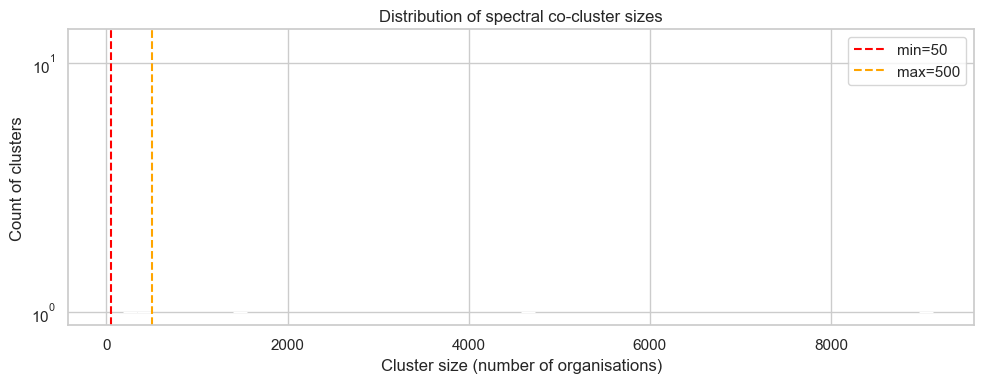

In [142]:
plt.figure(figsize=(10, 4))
sns.histplot(cluster_sizes_series, bins=60, log_scale=(False, True))
plt.axvline(MIN_CLUSTER_SIZE, color="red", linestyle="--", label=f"min={MIN_CLUSTER_SIZE}")
plt.axvline(MAX_CLUSTER_SIZE, color="orange", linestyle="--", label=f"max={MAX_CLUSTER_SIZE}")
plt.xlabel("Cluster size (number of organisations)")
plt.ylabel("Count of clusters")
plt.title("Distribution of spectral co-cluster sizes")
plt.legend()
plt.tight_layout()
plt.show()


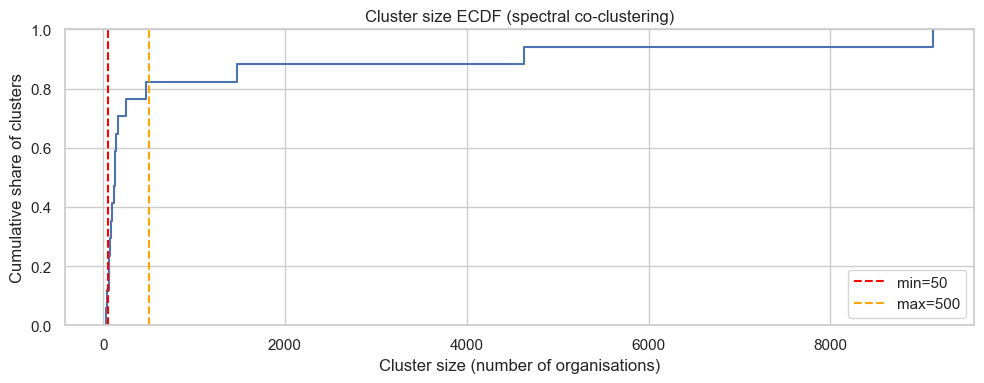

In [143]:
plt.figure(figsize=(10, 4))
sns.ecdfplot(cluster_sizes_series, complementary=False)
plt.axvline(MIN_CLUSTER_SIZE, color="red", linestyle="--", label=f"min={MIN_CLUSTER_SIZE}")
plt.axvline(MAX_CLUSTER_SIZE, color="orange", linestyle="--", label=f"max={MAX_CLUSTER_SIZE}")
plt.xlabel("Cluster size (number of organisations)")
plt.ylabel("Cumulative share of clusters")
plt.title("Cluster size ECDF (spectral co-clustering)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


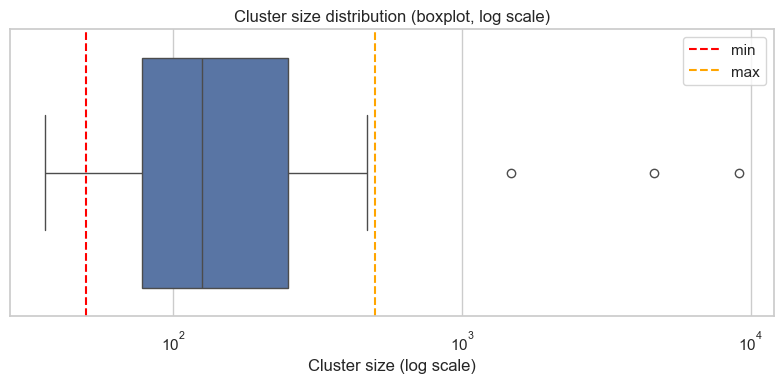

In [144]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=cluster_sizes_series.values)
plt.xscale("log")
plt.axvline(MIN_CLUSTER_SIZE, color="red", linestyle="--", label="min")
plt.axvline(MAX_CLUSTER_SIZE, color="orange", linestyle="--", label="max")
plt.xlabel("Cluster size (log scale)")
plt.title("Cluster size distribution (boxplot, log scale)")
plt.legend()
plt.tight_layout()
plt.show()


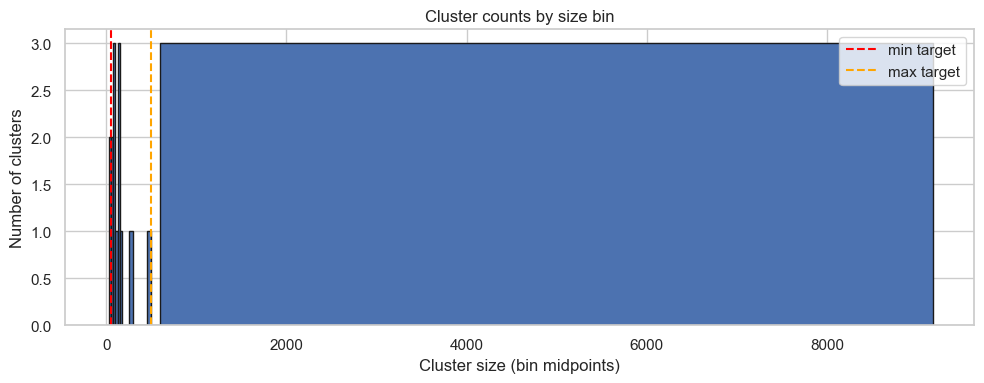

In [145]:
bin_edges = np.concatenate([
    np.arange(0, 200, 25),
    np.arange(200, 600, 50),
    np.array([600, cluster_sizes_series.max() + 50])
])
size_counts, _ = np.histogram(cluster_sizes_series.values, bins=bin_edges)
size_bins_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(10, 4))
plt.bar(size_bins_mid, size_counts, width=np.diff(bin_edges), align="center", edgecolor="k")
plt.axvline(MIN_CLUSTER_SIZE, color="red", linestyle="--", label="min target")
plt.axvline(MAX_CLUSTER_SIZE, color="orange", linestyle="--", label="max target")
plt.xlabel("Cluster size (bin midpoints)")
plt.ylabel("Number of clusters")
plt.title("Cluster counts by size bin")
plt.legend()
plt.tight_layout()
plt.show()



In [146]:
output_path = data_dir / (
    f"contract_graph_edges_cocluster_k{SPECTRAL_K}_range{MIN_CLUSTER_SIZE}-{MAX_CLUSTER_SIZE}.csv"
)
filtered_edges.to_csv(output_path, index=False)
output_path


WindowsPath('C:/Users/takat/OneDrive/Documents/Programming/EKR/data/contract_graph_edges_cocluster_k120_range50-500.csv')